In [1]:
import lenstronomy.Util.simulation_util as sim_util
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.Util import param_util
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter

## Datacube specifications

In [2]:
num_pixel = 35
x_size, y_size = num_pixel, num_pixel
pixel_size = 0.1  # spatial pixel size
psf_fwhm = 0.2

wavelength_start = 0.9703180286160205  # um
wavelength_end = 1.2  # um
wavelength_pixel_size = 0.0006360000115819275  # um
wavelength_lsf_fwhm = wavelength_pixel_size * 2  # nm


# lens specifications
theta_E = 1.0
gamma = 2.0
q = 0.6
phi = 0.0
R_eff = 1.0

z_lens = 0.3
z_source = 1.0

## Simulate light distributions

/Users/ajshajib/Vault/software_dev/lenstronomy/lenstronomy/LensModel/Profiles/epl.py:297: RuntimeWarning: invalid value encountered in divide
  R_omega = Z * hyp2f1(1, t / 2, 2 - t / 2, -(1 - q) / (1 + q) * (Z / Z.conj()))
/Users/ajshajib/Vault/software_dev/lenstronomy/lenstronomy/LensModel/Profiles/epl.py:322: RuntimeWarning: invalid value encountered in divide
  cos, sin = x / r, y / r
/Users/ajshajib/Vault/software_dev/lenstronomy/lenstronomy/LensModel/Profiles/epl.py:322: RuntimeWarning: invalid value encountered in scalar divide
  cos, sin = x / r, y / r
/var/folders/bn/g_64xdl56nj_f4wtmm1_bk9h0000gn/T/ipykernel_18600/1710979659.py:138: RuntimeWarning: divide by zero encountered in log10
  axes[2].matshow(np.log10(point_source_light), origin="lower", vmin=-1, vmax=2)


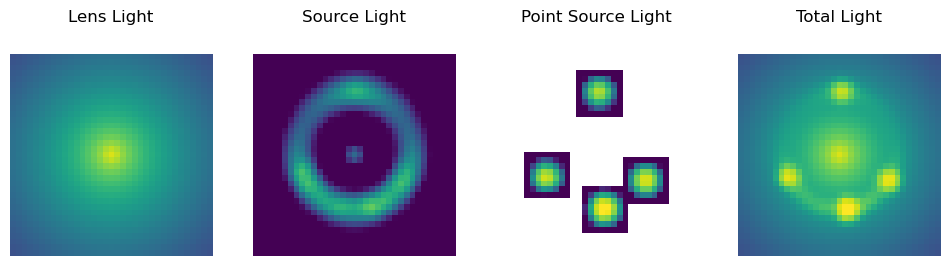

In [3]:
# set noise to zero for now, it will be added later in the datacube
background_rms = 0.0  # background noise per pixel
exposure_time = np.inf

kwargs_data = sim_util.data_configure_simple(
    num_pixel, pixel_size, exposure_time, background_rms
)
data_class = ImageData(**kwargs_data)

kwargs_psf = {
    "psf_type": "GAUSSIAN",
    "fwhm": psf_fwhm,
    "pixel_size": pixel_size,
    "truncation": 5,
}
psf_class = PSF(**kwargs_psf)

lens_model_list = ["EPL"]

e1, e2 = param_util.phi_q2_ellipticity(phi, q)
kwargs_lens = [
    {
        "theta_E": theta_E,
        "gamma": 2.5,
        "center_x": 0,
        "center_y": 0,
        "e1": e1,
        "e2": e2,
    }
]
lens_model_class = LensModel(lens_model_list=lens_model_list)


lens_light_model_list = ["SERSIC"]
kwargs_lens_light = [
    {
        "amp": 400,
        "R_sersic": 1.0,
        "n_sersic": 2,
        "center_x": 0,
        "center_y": 0,
    }
]
lens_light_model_class = LightModel(light_model_list=lens_light_model_list)

source_model_list = ["SERSIC_ELLIPSE"]
ra_source, dec_source = 0.01, 0.1
kwargs_source = [
    {
        "amp": 400.0,
        "R_sersic": 0.1,
        "n_sersic": 3,
        "center_x": ra_source,
        "center_y": dec_source,
        "e1": -0.1,
        "e2": 0.01,
    }
]
source_model_class = LightModel(light_model_list=source_model_list)

lens_equation_solver = LensEquationSolver(lens_model_class)
x_image, y_image = lens_equation_solver.findBrightImage(
    ra_source,
    dec_source,
    kwargs_lens,
    numImages=4,
    min_distance=pixel_size,
    search_window=num_pixel * pixel_size,
)

image_magnifications = lens_model_class.magnification(
    x_image, y_image, kwargs=kwargs_lens
)
image_magnifications = np.abs(
    image_magnifications
)  # ignore the sign of the magnification

point_amp = image_magnifications * 100
kwargs_ps = [{"ra_image": x_image, "dec_image": y_image, "point_amp": point_amp}]

point_source_list = ["LENSED_POSITION"]
point_source_class = PointSource(
    point_source_type_list=point_source_list, fixed_magnification_list=[False]
)

kwargs_numerics = {"supersampling_factor": 1, "supersampling_convolution": False}

image_model = ImageModel(
    data_class,
    psf_class,
    lens_model_class,
    source_model_class,
    lens_light_model_class,
    point_source_class,
    kwargs_numerics=kwargs_numerics,
)

lens_light = image_model.image(
    kwargs_lens,
    kwargs_source,
    kwargs_lens_light,
    kwargs_ps,
    source_add=False,
    lens_light_add=True,
    point_source_add=False,
)

source_light = image_model.image(
    kwargs_lens,
    kwargs_source,
    kwargs_lens_light,
    kwargs_ps,
    source_add=True,
    lens_light_add=False,
    point_source_add=False,
)

point_source_light = image_model.image(
    kwargs_lens,
    kwargs_source,
    kwargs_lens_light,
    kwargs_ps,
    source_add=False,
    lens_light_add=False,
    point_source_add=True,
)

fig, axes = plt.subplots(1, 4, figsize=(12, 4))

axes[0].matshow(np.log10(lens_light), origin="lower", vmin=-1, vmax=2)
axes[0].set_title("Lens Light")
axes[0].axis("off")

axes[1].matshow(np.log10(source_light), origin="lower", vmin=-1, vmax=2)
axes[1].set_title("Source Light")
axes[1].axis("off")

axes[2].matshow(np.log10(point_source_light), origin="lower", vmin=-1, vmax=2)
axes[2].set_title("Point Source Light")
axes[2].axis("off")

axes[3].matshow(
    np.log10(lens_light + source_light + point_source_light),
    origin="lower",
    vmin=-1,
    vmax=2,
)
axes[3].set_title("Total Light")
axes[3].axis("off")

plt.show()

## Simulate velocity dispersion field

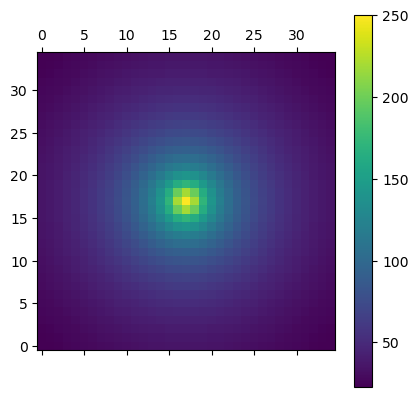

In [4]:
velocity_dispersion_field = (
    np.ones_like(lens_light) * 250 * np.sqrt(lens_light / np.max(lens_light))
)

plt.matshow(velocity_dispersion_field, origin="lower")
plt.colorbar()

## Simulate spectra

In [5]:
def load_template(filename):
    """Get the template from a file.

    :param filename: str, path to the file
    """
    template, header = fits.getdata(filename, header=True)

    wavelengths = []
    fluxes = []
    for element in template:
        wavelengths.append(element[0] / 1e4)
        fluxes.append(element[1])

    interp_func = interp1d(wavelengths, fluxes, kind="cubic")

    return interp_func

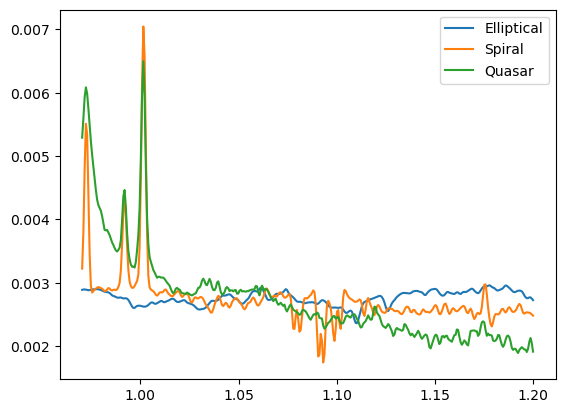

In [6]:
elliptical_template = load_template("data/elliptical_template.fits")
spiral_template = load_template("data/starb4_template.fits")
quasar_template = load_template("data/qso_template.fits")


wavelengths = np.arange(wavelength_start, wavelength_end, wavelength_pixel_size)

wavelength_lsf_std = wavelength_lsf_fwhm / 2.355 / wavelength_pixel_size

elliptical_spectra = elliptical_template(wavelengths / (1 + z_lens))
elliptical_spectra /= np.sum(elliptical_spectra)
elliptical_spectra = gaussian_filter(elliptical_spectra, wavelength_lsf_std)

spiral_spectra = spiral_template(wavelengths / (1 + z_source))
spiral_spectra /= np.sum(spiral_spectra)
spiral_spectra = gaussian_filter(spiral_spectra, wavelength_lsf_std)

quasar_spectra = quasar_template(wavelengths / (1 + z_source))
quasar_spectra /= np.sum(quasar_spectra)
quasar_spectra = gaussian_filter(quasar_spectra, wavelength_lsf_std)

plt.plot(wavelengths, elliptical_spectra, label="Elliptical")
plt.plot(wavelengths, spiral_spectra, label="Spiral")
plt.plot(wavelengths, quasar_spectra, label="Quasar")
plt.legend()
plt.show()

## Make datacube

In [7]:
source_data_cube = np.zeros((num_pixel, num_pixel, len(wavelengths)))
quasar_data_cube = np.zeros((num_pixel, num_pixel, len(wavelengths)))
lens_data_cube = np.zeros((num_pixel, num_pixel, len(wavelengths)))

for i in range(num_pixel):
    for j in range(num_pixel):
        source_data_cube[i, j, :] = source_light[i, j] * spiral_spectra
        quasar_data_cube[i, j, :] = point_source_light[i, j] * quasar_spectra

        # convolve spectra with velocity dispersion
        speed_of_light = 299792.458  # km/s
        dispersion_std = (
            velocity_dispersion_field[i, j]
            / speed_of_light
            * np.mean(wavelengths)
            / wavelength_pixel_size
        )

        lens_data_cube = lens_light[:, :, np.newaxis] * gaussian_filter(
            elliptical_spectra, dispersion_std
        )

datacube = source_data_cube + quasar_data_cube + lens_data_cube

datacube = np.transpose(datacube, axes=(2, 0, 1))

print(f"Datacube shape: {datacube.shape}")

Datacube shape: (362, 35, 35)


In [8]:
# make noise cube

central_spaxel_snr = 30

factor = (
    1.0
    / np.median(lens_data_cube[:, num_pixel // 2, num_pixel // 2])
    * central_spaxel_snr**2
)

datacube *= factor
noise_cube = np.sqrt(datacube)

np.random.seed(37)

datacube += np.random.normal(0, 1, datacube.shape) * noise_cube

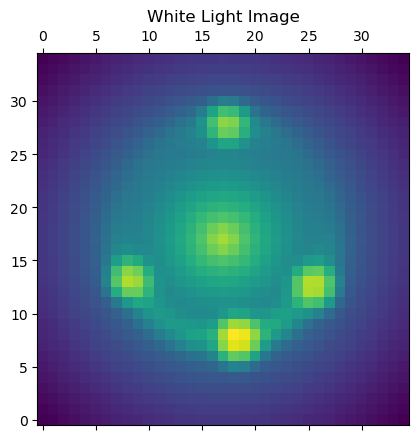

In [9]:
plt.matshow(np.log10(np.nansum(datacube, axis=0)), origin="lower")
plt.title("White Light Image")
plt.show()

In [10]:
# save the datacube to a fits file
header = fits.Header()
header["NAXIS"] = 3
header["NAXIS1"] = num_pixel
header["NAXIS2"] = num_pixel
header["NAXIS3"] = len(wavelengths)
header["CRPIX1"] = num_pixel // 2
header["CRPIX2"] = num_pixel // 2
header["CRVAL1"] = 0.0
header["CRVAL2"] = 0.0
header["CDELT1"] = pixel_size / 3600.0
header["CDELT2"] = pixel_size / 3600.0
header["CTYPE1"] = "RA---TAN"
header["CTYPE2"] = "DEC--TAN"
header["CRPIX3"] = 1
header["CRVAL3"] = wavelength_start
header["CDELT3"] = wavelength_pixel_size
header["PC1_1"] = -1.0
header["PC1_2"] = 0.0
header["PC2_1"] = 0.0
header["PC2_2"] = 1.0
header["CTYPE3"] = "WAVE    "
header["BUNIT"] = "arbitrar"
header["CUNIT1"] = "deg     "
header["CUNIT2"] = "deg     "
header["CUNIT3"] = "um     "

# with open("./data/mock_datacube.fits", "wb") as f:
hdu1 = fits.PrimaryHDU(data=datacube, header=header)
hdu2 = fits.ImageHDU(data=noise_cube)
new_hdul = fits.HDUList([hdu1, hdu2])
new_hdul.writeto("./data/mock_datacube.fits", overwrite=True)
# fits.writeto(f, datacube, header=header, overwrite=True)